# Lambda School Data Science - Quantile Regression

Regressing towards the median - or any quantile - as a way to mitigate outliers and control risk.

## Lecture

Let's look at data that has a bit of a skew to it:

http://archive.ics.uci.edu/ml/datasets/Beijing+PM2.5+Data

In [6]:
import pandas as pd
df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/'
                 '00381/PRSA_data_2010.1.1-2014.12.31.csv')

In [7]:
df.head()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,cbwd,Iws,Is,Ir
0,1,2010,1,1,0,NaN,-21,-11.0,1021.0,NW,1.79,0,0
1,2,2010,1,1,1,NaN,-21,-12.0,1020.0,NW,4.92,0,0
2,3,2010,1,1,2,NaN,-21,-11.0,1019.0,NW,6.71,0,0
3,4,2010,1,1,3,NaN,-21,-14.0,1019.0,NW,9.84,0,0
4,5,2010,1,1,4,NaN,-20,-12.0,1018.0,NW,12.97,0,0


In [8]:
df.describe()

,No,year,month,day,hour,pm2.5,DEWP,TEMP,PRES,Iws,Is,Ir
count,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,41757.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000,43824.000000
mean,21912.500000,2012.000000,6.523549,15.727820,11.500000,98.613215,1.817246,12.448521,1016.447654,23.889140,0.052734,0.194916
std,12651.043435,1.413842,3.448572,8.799425,6.922266,92.050387,14.433440,12.198613,10.268698,50.010635,0.760375,1.415867
min,1.000000,2010.000000,1.000000,1.000000,0.000000,0.000000,-40.000000,-19.000000,991.000000,0.450000,0.000000,0.000000
25%,10956.750000,2011.000000,4.000000,8.000000,5.750000,29.000000,-10.000000,2.000000,1008.000000,1.790000,0.000000,0.000000
50%,21912.500000,2012.000000,7.000000,16.000000,11.500000,72.000000,2.000000,14.000000,1016.000000,5.370000,0.000000,0.000000
75%,32868.250000,2013.000000,10.000000,23.000000,17.250000,137.000000,15.000000,23.000000,1025.000000,21.910000,0.000000,0.000000
max,43824.000000,2014.000000,12.000000,31.000000,23.000000,994.000000,28.000000,42.000000,1046.000000,585.600000,27.000000,36.000000


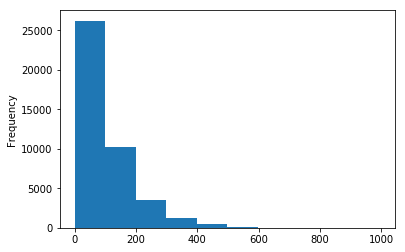

In [9]:
df['pm2.5'].plot.hist();

In [10]:
# How does linear regression handle it?
from sklearn.linear_model import LinearRegression

# Let's drop NAs and limit to numeric values
df = df._get_numeric_data().dropna()
X = df.drop('pm2.5', axis='columns')
y = df['pm2.5']

linear_reg = LinearRegression().fit(X, y)
linear_reg.score(X, y)

0.2590006399659215

In [12]:
# Not bad - but what if we wanted to model the distribution more conservatively?
# Let's try quantile
import statsmodels.formula.api as smf

# Different jargon/API in StatsModel documentation
# "endogenous" response var is dependent (y), it is "inside"
# "exogenous" variables are independent (X), it is "outside"
# Bonus points - talk about "exogenous shocks" and you're a bona fide economist

# ~ style formulas look like what R uses
# y ~ x1 + x2 + ...
# Also, these formulas break with . in variable name, so lets change that
df = df.rename(index=str, columns={'pm2.5': 'pm25'})

# Now let's construct the formula string using all columns
quant_formula = 'pm25 ~ ' + ' + '.join(df.drop('pm25', axis='columns').columns)
print(quant_formula)

quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.5)
quant_reg.summary()  # "summary" is another very R-thing

pm25 ~ No + year + month + day + hour + DEWP + TEMP + PRES + Iws + Is + Ir


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                   pm25   Pseudo R-squared:               0.1600
Model:                       QuantReg   Bandwidth:                       8.276
Method:                 Least Squares   Sparsity:                        133.8
Date:                Wed, 23 Jan 2019   No. Observations:                41757
Time:                        12:26:38   Df Residuals:                    41745
                                        Df Model:                           11
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0004   1.67e-05     22.881      0.000       0.000       0.000
No           3.63e-07   2.67e-05      0.014      0.989    -5.2e-05    5.27e-05
year           0.8830      0.031     28.631      0.000       0.823       0.943
month         -1.4110      0.103    -13.749      0.000      -1.612      -1.210
day            0.4461      0.037     11.951      0.000       0.373       0.519
hour           1.2810      0.050     25.779      0.000       1.184       1.378
DEWP           3.6362      0.047     77.315      0.000       3.544       3.728
TEMP          -4.7103      0.060    -78.779      0.000      -4.828      -4.593
PRES          -1.6265      0.061    -26.760      0.000      -1.746      -1.507
Iws           -0.1541      0.007    -21.786      0.000      -0.168      -0.140
Is            -1.6322      0.425     -3.838      0.000      -2.466      -0.799
Ir            -5.3946      0.234    -23.034      0.000      -5.854      -4.936
==============================================================================

The condition number is large, 3.67e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

That fit to the median (q=0.5), also called "Least Absolute Deviation." The pseudo-R^2 isn't really directly comparable to the R^2 from linear regression, but it clearly isn't dramatically improved. Can we make it better?

In [0]:
help(quant_mod.fit)

Help on method fit in module statsmodels.regression.quantile_regression:

fit(q=0.5, vcov='robust', kernel='epa', bandwidth='hsheather', max_iter=1000, p_tol=1e-06, **kwargs) method of statsmodels.regression.quantile_regression.QuantReg instance
    Solve by Iterative Weighted Least Squares
    
    Parameters
    ----------
    q : float
        Quantile must be between 0 and 1
    vcov : string, method used to calculate the variance-covariance matrix
        of the parameters. Default is ``robust``:
    
        - robust : heteroskedasticity robust standard errors (as suggested
          in Greene 6th edition)
        - iid : iid errors (as in Stata 12)
    
    kernel : string, kernel to use in the kernel density estimation for the
        asymptotic covariance matrix:
    
        - epa: Epanechnikov
        - cos: Cosine
        - gau: Gaussian
        - par: Parzene
    
    bandwidth: string, Bandwidth selection method in kernel density
        estimation for asymptotic covarian

In [14]:
quantiles = (.05, .96, .1)

for quantile in quantiles:
    print(quant_mod.fit(q=quantile).summary())

                         QuantReg Regression Results                          
Dep. Variable:                   pm25   Pseudo R-squared:              0.04130
Model:                       QuantReg   Bandwidth:                       8.908
Method:                 Least Squares   Sparsity:                        120.7
Date:                Wed, 23 Jan 2019   No. Observations:                41757
Time:                        12:35:20   Df Residuals:                    41745
                                        Df Model:                           11
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   3.072e-05    6.4e-06      4.803      0.000    1.82e-05    4.33e-05
No         -6.994e-05   9.59e-06     -7.292      0.000   -8.87e-05   -5.11e-05
year           0.0998      0.012      8.275      0.000       0.076       0.123
month         -0.4536      0.034    -13.419      0.0

"Strong multicollinearity", eh? In other words - maybe we shouldn't throw every variable in our formula. Let's hand-craft a smaller one, picking the features with the largest magnitude t-statistics for their coefficients. Let's also search for more quantile cutoffs to see what's most effective.

In [15]:
quant_formula = 'pm25 ~ DEWP + TEMP + Ir + hour + Iws'
quant_mod = smf.quantreg(quant_formula, data=df)
for quantile in range(50, 100):
    quantile /= 100
    quant_reg = quant_mod.fit(q=quantile)
    print((quantile, quant_reg.prsquared))

(0.5, 0.1447879336023583)
(0.51, 0.1453046499109799)
(0.52, 0.1457984456251047)
(0.53, 0.14627848333343263)
(0.54, 0.1467640446791706)
(0.55, 0.14733094668790292)
(0.56, 0.14787821797693512)
(0.57, 0.14840185621049273)
(0.58, 0.14892138273908107)
(0.59, 0.14946793972061212)


/Users/zach/anaconda3/lib/python3.6/site-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


(0.6, 0.1500450836285967)
(0.61, 0.15066665485612274)
(0.62, 0.15131550520931825)
(0.63, 0.15201598245712966)
(0.64, 0.152815632180745)
(0.65, 0.15360133883660188)
(0.66, 0.15440046026580068)
(0.67, 0.15521251759239985)
(0.68, 0.15607615678951559)
(0.69, 0.15692695615298136)
(0.7, 0.1577663389046554)
(0.71, 0.15865286212994567)
(0.72, 0.15961363441229715)
(0.73, 0.16062991121153458)
(0.74, 0.1617151201897239)
(0.75, 0.16280951619867146)
(0.76, 0.16394259393342125)
(0.77, 0.16517451474458056)
(0.78, 0.1664423443710097)
(0.79, 0.16770815353095714)


/Users/zach/anaconda3/lib/python3.6/site-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


(0.8, 0.16904227356438506)
(0.81, 0.17037126968955685)
(0.82, 0.17195593122357777)
(0.83, 0.17383892606382623)
(0.84, 0.17599918426382777)
(0.85, 0.17817588507328963)
(0.86, 0.18047434708570964)
(0.87, 0.18274842963575832)
(0.88, 0.1850748927825704)
(0.89, 0.18767194363846373)
(0.9, 0.1899871464061209)
(0.91, 0.19205778885867675)
(0.92, 0.19409258046839573)
(0.93, 0.1960928580149024)
(0.94, 0.1990718585613529)
(0.95, 0.20306510227274233)
(0.96, 0.20828854295993626)
(0.97, 0.21268428179968246)
(0.98, 0.21668870123970496)
(0.99, 0.21742941318156628)


In [0]:
# Okay, this data seems *extremely* skewed
# Let's trying logging
import numpy as np

df['pm25'] = np.log(1 + df['pm25'])
quant_mod = smf.quantreg(quant_formula, data=df)
quant_reg = quant_mod.fit(q=.25)
quant_reg.summary()  # "summary" is another very R-thing

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                   pm25   Pseudo R-squared:               0.2614
Model:                       QuantReg   Bandwidth:                     0.01908
Method:                 Least Squares   Sparsity:                       0.6060
Date:                Mon, 21 Jan 2019   No. Observations:                41757
Time:                        00:41:40   Df Residuals:                    41745
                                        Df Model:                           11
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.016e-06   6.52e-08     15.579      0.000    8.88e-07    1.14e-06
No         -7.472e-07   1.01e-07     -7.406      0.000   -9.45e-07   -5.49e-07
year           0.0027      0.000     21.867      0.000       0.002       0.003
month         -0.0075      0.000    -19.825      0.000      -0.008      -0.007
day            0.0014      0.000      9.770      0.000       0.001       0.002
hour           0.0049      0.000     23.971      0.000       0.004       0.005
DEWP           0.0155      0.000     89.454      0.000       0.015       0.016
TEMP          -0.0172      0.000    -77.079      0.000      -0.018      -0.017
PRES          -0.0036      0.000    -14.870      0.000      -0.004      -0.003
Iws           -0.0010   2.42e-05    -39.707      0.000      -0.001      -0.001
Is            -0.0025      0.002     -1.517      0.129      -0.006       0.001
Ir            -0.0235      0.001    -29.010      0.000      -0.025      -0.022
==============================================================================

The condition number is large, 3.67e+10. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Overall - in this case, quantile regression is not *necessarily* superior to linear regression. But it does give us extra flexibility and another thing to tune - what the center of what we're actually fitting in the dependent variable.

The basic case of `q=0.5` (the median) minimizes the absolute value of residuals, while OLS minimizes the squared value. By selecting `q=0.25`, we're targeting a lower quantile and are effectively saying that we only want to over-estimate at most 25% of the time - we're being *risk averse*.

Depending on the data you're looking at, and the cost of making a false positive versus a false negative, this sort of flexibility can be extremely useful.

Live - let's consider another dataset! Specifically, "SkillCraft" (data on competitive StarCraft players): http://archive.ics.uci.edu/ml/datasets/SkillCraft1+Master+Table+Dataset

In [16]:
# TODO Live!
# Hint - we may only care about the *top* quantiles here
# Another hint - there are missing values, but Pandas won't see them right away

skill = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/00272/SkillCraft1_Dataset.csv')

In [24]:
import numpy as np
skill.replace('?', np.nan, inplace=True)
skill.isnull().sum()

GameID                   0
LeagueIndex              0
Age                     55
HoursPerWeek            56
TotalHours              57
APM                      0
SelectByHotkeys          0
AssignToHotkeys          0
UniqueHotkeys            0
MinimapAttacks           0
MinimapRightClicks       0
NumberOfPACs             0
GapBetweenPACs           0
ActionLatency            0
ActionsInPAC             0
TotalMapExplored         0
WorkersMade              0
UniqueUnitsMade          0
ComplexUnitsMade         0
ComplexAbilitiesUsed     0
dtype: int64

In [27]:
# replacing missing values for Age, HoursPerWeek, TotalHours
skill['Age'] = skill['Age'].fillna(skill['Age'].median())
skill['HoursPerWeek'] = skill['HoursPerWeek'].fillna(skill['HoursPerWeek'].median())
skill['TotalHours'] = skill['TotalHours'].fillna(skill['TotalHours'].median())
print ('Total nulls', skill.isnull().sum().sum())

Total nulls 0


In [29]:
# check dtypes
skill.dtypes

GameID                    int64
LeagueIndex               int64
Age                      object
HoursPerWeek             object
TotalHours               object
APM                     float64
SelectByHotkeys         float64
AssignToHotkeys         float64
UniqueHotkeys             int64
MinimapAttacks          float64
MinimapRightClicks      float64
NumberOfPACs            float64
GapBetweenPACs          float64
ActionLatency           float64
ActionsInPAC            float64
TotalMapExplored          int64
WorkersMade             float64
UniqueUnitsMade           int64
ComplexUnitsMade        float64
ComplexAbilitiesUsed    float64
dtype: object

In [33]:
# correcting object types
skill['Age'] = pd.to_numeric(skill['Age'])
skill['HoursPerWeek'] = pd.to_numeric(skill['HoursPerWeek'])
skill['TotalHours'] = pd.to_numeric(skill['TotalHours'])

In [36]:
# predicting top 10% of players in APM
target = 'APM'
features = skill.columns.drop(target)

X = skill[features]
y = skill[target]

In [37]:
quant_formula_skill = 'APM ~ ' + ' + '.join(X.columns)
print(quant_formula_skill)

quant_mod = smf.quantreg(quant_formula_skill, data=skill)
quant_reg = quant_mod.fit(q=.9)
quant_reg.summary()  # "summary" is another very R-thing

APM ~ GameID + LeagueIndex + Age + HoursPerWeek + TotalHours + SelectByHotkeys + AssignToHotkeys + UniqueHotkeys + MinimapAttacks + MinimapRightClicks + NumberOfPACs + GapBetweenPACs + ActionLatency + ActionsInPAC + TotalMapExplored + WorkersMade + UniqueUnitsMade + ComplexUnitsMade + ComplexAbilitiesUsed


/Users/zach/anaconda3/lib/python3.6/site-packages/statsmodels/regression/quantile_regression.py:193: IterationLimitWarning: Maximum number of iterations (1000) reached.
  ") reached.", IterationLimitWarning)


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    APM   Pseudo R-squared:               0.4341
Model:                       QuantReg   Bandwidth:                       7.626
Method:                 Least Squares   Sparsity:                        196.8
Date:                Wed, 23 Jan 2019   No. Observations:                 3395
Time:                        13:32:10   Df Residuals:                     3375
                                        Df Model:                           19
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                0.3321     24.196      0.014      0.989     -47.109      47.773
GameID                   0.0026      0.000      6.395      0.000       0.002       0.003
LeagueIndex             16.7656      1.268     13.219      0.000      14.279      19.252
Age                      0.5498      0.266      2.070      0.039       0.029       1.070
HoursPerWeek             0.4596      0.081      5.689      0.000       0.301       0.618
TotalHours            7.541e-05   2.32e-05      3.256      0.001       3e-05       0.000
SelectByHotkeys          0.0272    560.946   4.85e-05      1.000   -1099.801    1099.856
AssignToHotkeys          0.0006    366.906   1.72e-06      1.000    -719.379     719.381
UniqueHotkeys            4.2447      0.500      8.485      0.000       3.264       5.226
MinimapAttacks          -0.0011    297.638  -3.56e-06      1.000    -583.571     583.569
MinimapRightClicks       0.0034   3568.224   9.54e-07      1.000   -6996.095    6996.102
NumberOfPACs             0.0046   3627.445   1.27e-06      1.000   -7112.208    7112.217
GapBetweenPACs           0.2005      0.093      2.146      0.032       0.017       0.384
ActionLatency           -0.7911      0.171     -4.632      0.000      -1.126      -0.456
ActionsInPAC            14.4647      1.018     14.205      0.000      12.468      16.461
TotalMapExplored         0.6222      0.179      3.483      0.001       0.272       0.972
WorkersMade              0.0053   2086.179   2.54e-06      1.000   -4090.298    4090.308
UniqueUnitsMade         -2.2514      0.690     -3.265      0.001      -3.604      -0.899
ComplexUnitsMade         0.0007    783.406    9.4e-07      1.000   -1535.998    1535.999
ComplexAbilitiesUsed     0.0005   3164.165   1.64e-07      1.000   -6203.873    6203.874
========================================================================================

The condition number is large, 2.14e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

LeagueIndex is a strong indicator of APM. 

In [40]:
quant_reg.predict(X.iloc[0, :])

0    180.527245
dtype: float64

## Assignment - birth weight data

Birth weight is a situation where, while the data itself is actually fairly normal and symmetric, our main goal is actually *not* to model mean weight (via OLS), but rather to identify mothers at risk of having children below a certain "at-risk" threshold weight.

Quantile regression gives us just the tool we need. For the data we are using, see: http://people.reed.edu/~jones/141/BirthWgt.html

    bwt: baby's weight in ounces at birth
    gestation: duration of pregnancy in days
    parity: parity indicator (first born = 1, later birth = 0)
    age: mother's age in years
    height: mother's height in inches
    weight: mother's weight in pounds (during pregnancy)
    smoke: indicator for whether mother smokes (1=yes, 0=no) 
    
Use this data and `statsmodels` to fit a quantile regression, predicting `bwt` (birth weight) as a function of the other covariates. First, identify an appropriate `q` (quantile) to target a cutoff of 90 ounces - babies above that birth weight are generally healthy/safe, babies below are at-risk.

Then, fit and iterate your model. Be creative! You may want to engineer features. Hint - mother's age likely is not simply linear in its impact, and the other features may interact as well.

At the end, create at least *2* tables and *1* visualization to summarize your best model. Then (in writing) answer the following questions:

- What characteristics of a mother indicate the highest likelihood of an at-risk (low weight) baby?
- What can expectant mothers be told to help mitigate this risk?

Note that second question is not exactly a data science question - and that's okay! You're not expected to be a medical expert, but it is a good exercise to do a little bit of digging into a particular domain and offer informal but informed opinions.

In [82]:
# imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split

In [45]:
bwt = pd.read_csv('http://people.reed.edu/~jones/141/Bwt.dat')
bwt.head()

,bwt,gestation,parity,age,height,weight,smoke
0,120,284,0,27,62,100,0
1,113,282,0,33,64,135,0
2,128,279,0,28,64,115,1
3,108,282,0,23,67,125,1
4,136,286,0,25,62,93,0


In [46]:
bwt.describe()

,bwt,gestation,parity,age,height,weight,smoke
count,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000,1174.000000
mean,119.462521,279.101363,0.262351,27.228279,64.049404,128.478705,0.390971
std,18.328671,16.010305,0.440100,5.817839,2.526102,20.734282,0.488176
min,55.000000,148.000000,0.000000,15.000000,53.000000,87.000000,0.000000
25%,108.000000,272.000000,0.000000,23.000000,62.000000,114.250000,0.000000
50%,120.000000,280.000000,0.000000,26.000000,64.000000,125.000000,0.000000
75%,131.000000,288.000000,1.000000,31.000000,66.000000,139.000000,1.000000
max,176.000000,353.000000,1.000000,45.000000,72.000000,250.000000,1.000000


'q' really doesnt have much to do with our 'cutoff' value, it has much more to do with our desired confidence in predictive output. For this analysis, let's say I want to make sure only 5% of true babies' weights are below my prediction.

It is much safer to operate with the assumption that a baby may be underweight (false positive) than to have too many false negatives, resulting in a baby not getting the proper treatment.

In [50]:
# predicting baby weights at 5% quantile
target = 'bwt'
features = bwt.columns.drop(target)

X = bwt[features]
y = bwt[target]

In [51]:
quant_formula_bwt = 'bwt ~ ' + ' + '.join(X.columns)
print(quant_formula_bwt)

quant_mod = smf.quantreg(quant_formula_bwt, data=bwt)
quant_reg = quant_mod.fit(q=.05)
quant_reg.summary()  # "summary" is another very R-thing

bwt ~ gestation + parity + age + height + weight + smoke


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    bwt   Pseudo R-squared:               0.2020
Model:                       QuantReg   Bandwidth:                       6.220
Method:                 Least Squares   Sparsity:                        139.7
Date:                Wed, 23 Jan 2019   No. Observations:                 1174
Time:                        16:14:45   Df Residuals:                     1167
                                        Df Model:                            6
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -104.4731     32.656     -3.199      0.001    -168.545     -40.401
gestation      0.5048      0.093      5.426      0.000       0.322       0.687
parity        -3.5096      2.388     -1.470      0.142      -8.194       1.175
age           -0.0771      0.173     -0.446      0.656      -0.416       0.262
height         1.2676      0.426      2.977      0.003       0.432       2.103
weight        -0.1402      0.058     -2.436      0.015      -0.253      -0.027
smoke         -7.9833      1.823     -4.378      0.000     -11.561      -4.406
==============================================================================

The condition number is large, 9.8e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

A couple issues from this first regression

1. Mutlicollinearity

This likely results from age, parity, height, and weight in some combination. Parity does not seem to have much predictive power, maybe it would be best to drop this. Let's see how it behaves in the next regression and go from there.

Height and weight may be best to combine into a relative measure of the two, such as BMI.

2. Age is not statistically significant

There is likely some inflection point for age. A 45+ year old woman having a child would intuitively seem more likely to have complications. Next time, we will try including this term.

In [56]:
# BMI term
bwt['bmi'] = bwt['weight'] / (bwt['height']**2)
# age squared term
bwt['age_squared'] = bwt['age'] ** 2

In [59]:
# re-run regression
# predicting baby weights at 5% quantile
target = 'bwt'
features = bwt.columns.drop([target, 'weight', 'height'])
X = bwt[features]
y = bwt[target]

quant_formula_bwt = 'bwt ~ ' + ' + '.join(X.columns)
print(quant_formula_bwt)

quant_mod = smf.quantreg(quant_formula_bwt, data=bwt)
quant_reg = quant_mod.fit(q=.05)
quant_reg.summary()  # "summary" is another very R-thing

bwt ~ gestation + parity + age + smoke + bmi + age_squared


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    bwt   Pseudo R-squared:               0.1953
Model:                       QuantReg   Bandwidth:                       6.508
Method:                 Least Squares   Sparsity:                        144.8
Date:                Wed, 23 Jan 2019   No. Observations:                 1174
Time:                        16:28:48   Df Residuals:                     1167
                                        Df Model:                            6
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept      -2.5878     34.130     -0.076      0.940     -69.552      64.376
gestation       0.4670      0.097      4.806      0.000       0.276       0.658
parity         -2.0126      2.534     -0.794      0.427      -6.985       2.960
age            -1.0133      1.455     -0.696      0.486      -3.868       1.842
smoke          -8.3208      1.925     -4.322      0.000     -12.098      -4.543
bmi          -491.8637    250.020     -1.967      0.049    -982.403      -1.325
age_squared     0.0158      0.024      0.651      0.515      -0.032       0.063
===============================================================================

The condition number is large, 1.97e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Parity still isn't statistically significant. Let's drop that.

Age, as well as its squared term, are not statistically significant. This is puzzling.

Let's take a step back and and plot some of our features against baby weight.

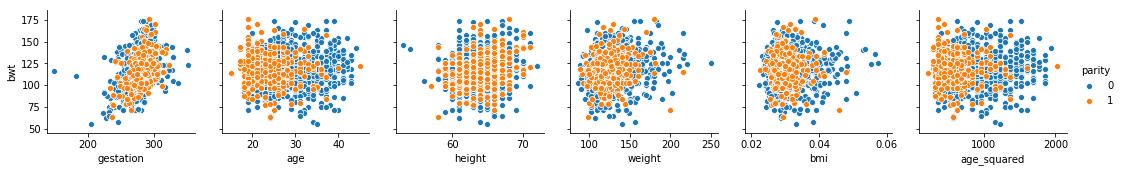

In [68]:
# pairplot with parity as hue
sns.pairplot(data=bwt, x_vars=bwt.columns.drop(['bwt', 'parity', 'smoke']), y_vars='bwt', hue='parity');

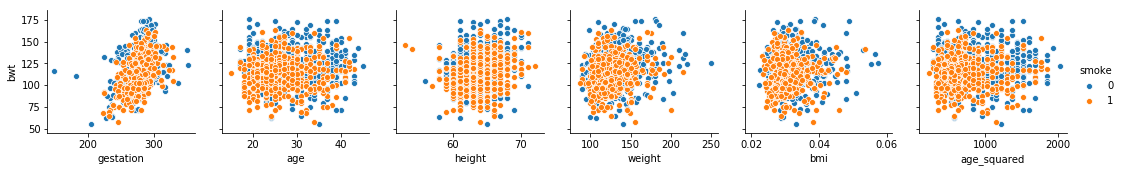

In [69]:
# pairplot with smoker as hue
sns.pairplot(data=bwt, x_vars=bwt.columns.drop(['bwt', 'parity', 'smoke']), y_vars='bwt', hue='smoke');

From the above, we can gain some intuition for relationships we haven't formalized in the model yet, including:

- young smokers seem more prone to have babies that weight less, especially the age_squared term
- smokers with early births (<260 weeks) seem prone to have babies that weight less
- age doesn't really seem to be strongly related to low-weight babies from these charts, confirming some of our intuition

In [76]:
# smokers with early births
bwt['smoke_earlybirth'] = (bwt['gestation'] < 260) * bwt['smoke']
# early births in general
bwt['earlybirth'] = bwt['gestation'] < 260
# age squared and smoke interaction term
bwt['age_squared_smoke'] = bwt['age_squared'] * bwt['smoke']
bwt.head()

,bwt,gestation,parity,age,height,weight,smoke,bmi,age_squared,smoke_earlybirth,age_squared_smoke,earlybirth
0,120,284,0,27,62,100,0,0.026015,729,0,0,False
1,113,282,0,33,64,135,0,0.032959,1089,0,0,False
2,128,279,0,28,64,115,1,0.028076,784,0,784,False
3,108,282,0,23,67,125,1,0.027846,529,0,529,False
4,136,286,0,25,62,93,0,0.024194,625,0,0,False


After adding some more variables, let's see what a full regression against the features looks like. We'll drop unnecessary variables from there.

In [77]:
# re-run regression
# predicting baby weights at 5% quantile
target = 'bwt'
features = bwt.columns.drop(target)
X = bwt[features]
y = bwt[target]

quant_formula_bwt = 'bwt ~ ' + ' + '.join(X.columns)
print(quant_formula_bwt)

quant_mod = smf.quantreg(quant_formula_bwt, data=bwt)
quant_reg = quant_mod.fit(q=.05)
quant_reg.summary()  # "summary" is another very R-thing

bwt ~ gestation + parity + age + height + weight + smoke + bmi + age_squared + smoke_earlybirth + age_squared_smoke + earlybirth


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    bwt   Pseudo R-squared:               0.2198
Model:                       QuantReg   Bandwidth:                       6.451
Method:                 Least Squares   Sparsity:                        130.4
Date:                Wed, 23 Jan 2019   No. Observations:                 1174
Time:                        17:03:16   Df Residuals:                     1162
                                        Df Model:                           11
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept            -44.2006    123.564     -0.358      0.721    -286.634     198.232
earlybirth[T.True]   -17.7607      5.205     -3.412      0.001     -27.973      -7.549
gestation              0.3408      0.116      2.939      0.003       0.113       0.568
parity                -0.4005      2.259     -0.177      0.859      -4.832       4.031
age                   -0.5378      1.238     -0.435      0.664      -2.966       1.891
height                 1.0927      1.978      0.552      0.581      -2.789       4.974
weight                -0.1010      0.465     -0.217      0.828      -1.013       0.810
smoke                -13.5320      4.256     -3.180      0.002     -21.882      -5.182
bmi                   -3.3847   1871.633     -0.002      0.999   -3675.542    3668.773
age_squared            0.0078      0.021      0.376      0.707      -0.033       0.048
smoke_earlybirth      11.2519      6.216      1.810      0.071      -0.943      23.447
age_squared_smoke      0.0048      0.005      0.934      0.350      -0.005       0.015
======================================================================================

The condition number is large, 2.58e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

An early birth seems to be by far the most powerful predictor. Let's drop features that aren't significant at alpha=.1 and re-run.

In [81]:
# re-run regression
# predicting baby weights at 5% quantile
target = 'bwt'
features = bwt.columns.drop([target, 'parity', 'age', 'height', 'weight', 'bmi', 
                             'age_squared', 'age_squared_smoke', 'smoke_earlybirth'])
X = bwt[features]
y = bwt[target]

quant_formula_bwt = 'bwt ~ ' + ' + '.join(X.columns)
print(quant_formula_bwt)

quant_mod = smf.quantreg(quant_formula_bwt, data=bwt)
quant_reg = quant_mod.fit(q=.05)
quant_reg.summary()  # "summary" is another very R-thing

bwt ~ gestation + smoke + earlybirth


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    bwt   Pseudo R-squared:               0.2021
Model:                       QuantReg   Bandwidth:                       6.434
Method:                 Least Squares   Sparsity:                        146.6
Date:                Wed, 23 Jan 2019   No. Observations:                 1174
Time:                        17:10:10   Df Residuals:                     1170
                                        Df Model:                            3
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              8.9538     34.837      0.257      0.797     -59.397      77.304
earlybirth[T.True]   -19.8615      5.030     -3.948      0.000     -29.731      -9.992
gestation              0.3231      0.124      2.615      0.009       0.081       0.565
smoke                -10.1231      1.924     -5.260      0.000     -13.899      -6.347
======================================================================================

The condition number is large, 6.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Our pseudo R-squared barely moves in this case. I know I've been cheating a bit by working with all of my data, but let's try this model for real by splitting it into a train and test set.

To validate, we will see what percent of the true test observations fall above and below the predicted value. If our model is working well, around 5% of results will fall below our predicted value.

In [97]:
# randomly split data into train and test
np.random.seed(1)
bwt['split'] = np.random.choice(['train', 'test'], size=bwt.shape[0], p=[0.67, 0.33])

bwt_train, bwt_test = bwt[bwt['split'] == 'train'], bwt[bwt['split'] == 'test']

X_train, y_train = bwt_train[features], bwt_train[target]
X_test, y_test = bwt_test[features], bwt_test[target]

quant_formula_bwt = 'bwt ~ ' + ' + '.join(X_train.columns)
print(quant_formula_bwt)

quant_mod = smf.quantreg(quant_formula_bwt, data=bwt_train)
quant_reg_final = quant_mod.fit(q=.05)
quant_reg_final.summary()  # "summary" is another very R-thing

bwt ~ gestation + smoke + earlybirth


<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    bwt   Pseudo R-squared:               0.2107
Model:                       QuantReg   Bandwidth:                       7.304
Method:                 Least Squares   Sparsity:                        122.5
Date:                Wed, 23 Jan 2019   No. Observations:                  780
Time:                        17:29:45   Df Residuals:                      776
                                        Df Model:                            3
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.6562     34.181      0.048      0.961     -65.442      68.754
earlybirth[T.True]   -16.7812      4.999     -3.357      0.001     -26.594      -6.969
gestation              0.3438      0.121      2.846      0.005       0.107       0.581
smoke                 -3.6250      2.019     -1.795      0.073      -7.589       0.339
======================================================================================

The condition number is large, 6.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [98]:
# validating results output
results = pd.DataFrame({'y_predicted': quant_reg_final.predict(X_test), 'y_true': y_test})
true_lt_predicted = (results['y_true'] < results['y_predicted']).astype(int)

print ('Actual percent of predictions lying below predicted y value:',
       round((true_lt_predicted.sum() * 1.0)/true_lt_predicted.count(), 3))

Actual percent of predictions lying below predicted y value: 0.056


## Summary

### Risk Factors and Mitigation

The coefficient estimations of our quartile regression model (q=0.05) is printed below.

The strongest predictors of the 5th quartile in birth weight are

1. An Early Birth : defined as a birth occurring earlier than 260 days
2. Gestation Period : the absolute amount of days a pregnancy has lasted
3. Smoking : A Mother who smokes decreases the expected 5th quartile birth rate

Note: late births likely come with their own complications, so 'gestation' should not be considered an absolutely beneficial feature of pregnancy. 

In [99]:
quant_reg_final.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                    bwt   Pseudo R-squared:               0.2107
Model:                       QuantReg   Bandwidth:                       7.304
Method:                 Least Squares   Sparsity:                        122.5
Date:                Wed, 23 Jan 2019   No. Observations:                  780
Time:                        17:30:15   Df Residuals:                      776
                                        Df Model:                            3
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              1.6562     34.181      0.048      0.961     -65.442      68.754
earlybirth[T.True]   -16.7812      4.999     -3.357      0.001     -26.594      -6.969
gestation              0.3438      0.121      2.846      0.005       0.107       0.581
smoke                 -3.6250      2.019     -1.795      0.073      -7.589       0.339
======================================================================================

The condition number is large, 6.48e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

To mitigate risks, mothers should avoid smoking and take steps (to the extent possible) to prevent early births from occurring. The Mayo Clinic lists the following risk factors for premature births:

- Having a previous premature birth
- Pregnancy with twins, triplets or other multiples
- An interval of less than six months between pregnancies
- Conceiving through in vitro fertilization
- Problems with the uterus, cervix or placenta
- Smoking cigarettes or using illicit drugs
- Some infections, particularly of the amniotic fluid and lower genital tract
- Some chronic conditions, such as high blood pressure and diabetes
- Being underweight or overweight before pregnancy
- Stressful life events, such as the death of a loved one or domestic violence
- Multiple miscarriages or abortions
- Physical injury or trauma

### Performance

As shown above, we an compare our predictions on the test data to the actual amount of baby weight points lying below our estimates. In our test data, only 5.6% of points lie below our estimated weight.

In [100]:
# validating results output
results = pd.DataFrame({'y_predicted': quant_reg_final.predict(X_test), 'y_true': y_test})
true_lt_predicted = (results['y_true'] < results['y_predicted']).astype(int)

print ('Actual percent of predictions lying below predicted y value:',
       round((true_lt_predicted.sum() * 1.0)/true_lt_predicted.count(), 3))

Actual percent of predictions lying below predicted y value: 0.056


Let's visualize our only final continuous feature, gestation period, and compare our predicted values to the actual results.

In [131]:
# create sample data for gestation, assuming smoking and no smoking
gestation = np.arange(175, 350, 0.5)
early_birth = np.where(gestation < 260, 1, 0)
X_plot_smoke = pd.DataFrame({'gestation' : gestation, 'smoke' : 1, 'earlybirth' : early_birth})
X_plot_nosmoke = pd.DataFrame({'gestation' : gestation, 'smoke' : 0, 'earlybirth' : early_birth})

y_plot_smoke, y_plot_nosmoke = quant_reg_final.predict(X_plot_smoke), quant_reg_final.predict(X_plot_nosmoke)

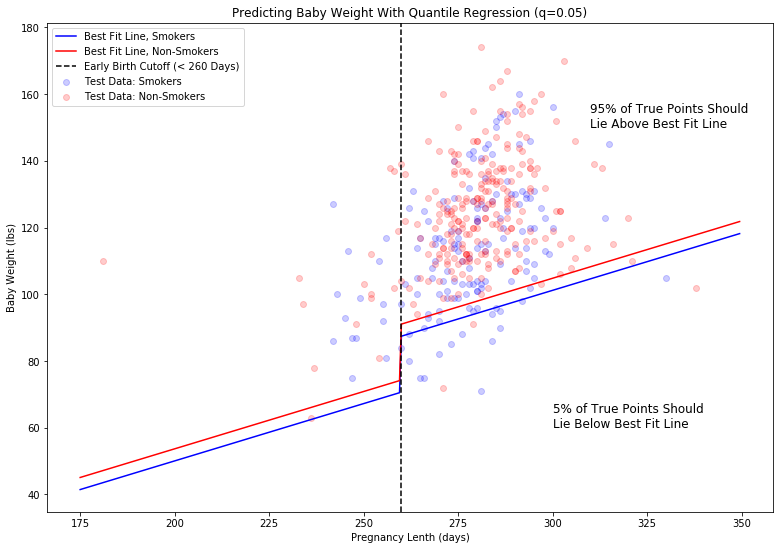

In [153]:
# plotting line of best fit for smokers
fig_smoke, ax_smoke = plt.subplots(figsize=(13,9))

ax_smoke.plot(X_plot_smoke['gestation'], y_plot_smoke, label='Best Fit Line, Smokers', c='blue')
ax_smoke.scatter(X_test['gestation'][X_test['smoke']==True], y_test[X_test['smoke']==True], 
                 alpha=0.2, 
                 c='blue',
                 label='Test Data: Smokers')

# plotting line of best fit and scatter plot for non-smokers
ax_smoke.plot(X_plot_nosmoke['gestation'], y_plot_nosmoke, label='Best Fit Line, Non-Smokers', c='red')
ax_smoke.scatter(X_test['gestation'][X_test['smoke']==False], y_test[X_test['smoke']==False], 
                 alpha=0.2, 
                 c='red',
                 label='Test Data: Non-Smokers')

# cutoff for early birth binary variable
ax_smoke.axvline(x=260, c='black', linestyle='--', label='Early Birth Cutoff (< 260 Days)')

# labeling
ax_smoke.set_ylabel('Baby Weight (lbs)')
ax_smoke.set_xlabel('Pregnancy Lenth (days)')
ax_smoke.legend(loc='upper left')
ax_smoke.set_title('Predicting Baby Weight With Quantile Regression (q=0.05)')

# annotations
ax_smoke.text(310, 150, '95% of True Points Should \nLie Above Best Fit Line', fontsize=12)
ax_smoke.text(300, 60, '5% of True Points Should \nLie Below Best Fit Line', fontsize=12)

plt.show()

## Resources and stretch goals

Resources:
- [statsmodels QuantReg example](http://www.statsmodels.org/dev/examples/notebooks/generated/quantile_regression.html)
- [How Shopify used Quantile Regression in modeling risk](https://medium.com/data-shopify/how-shopify-capital-uses-quantile-regression-to-help-merchants-succeed-10ee1b36b17d)
- [Intro to Quantile Regression](https://www.youtube.com/watch?v=pAKwoz05lK4)

Stretch goals:
- Find a dataset where you think quantile regression may be appropriate, and try both it and linear regression - compare/contrast their strengths/weaknesses, and write a summary for which you think is better for the situation and why
- Check out [deep quantile regression](https://www.kdnuggets.com/2018/07/deep-quantile-regression.html), an approach that uses a custom quantile loss function and Keras to train a quantile model